Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513 - Introdução ao Aprendizado de Máquina

**Aluno:** Rodrigo Kobashikawa Rosa<br>
**Matrícula:** 14201073
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$


# Exercício 9: Detecção de Anomalias e Sistemas de Recomendação

Neste exercício, você irá explorar duas aplicações de técnicas de aprendizado de máquina: estimação de densidade para detecção de anomalias, um problema de aprendizado não supervisionado; e um algoritmo de fatoração matricial para filtragem colaborativa em um sistema de recomendação.

In [ ]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_mldata
from scipy.stats import multivariate_normal

def plot_data(X, outliers=None, mean=None, cov=None):
    plt.scatter(X[:,0], X[:,1], marker='x')
    plt.axis('square')
    plt.axis([0, 30, 0, 30])
    plt.gcf().set_size_inches(5, 5)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (Mbit/s)');
    # circle outliers
    if outliers is not None:
        outliers = outliers > 0
        plt.scatter(X[outliers,0], X[outliers,1], c='none', marker='o', 
                    edgecolors='red', linewidths=2, s=100)
    # plot level curves corresponding to p = 10^-3, 10^-6, 10^-9, ...
    if mean is not None and cov is not None:
        X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
        XX = np.c_[X1.reshape(-1), X2.reshape(-1)]
        p = multivariate_normal(mean=mean, cov=cov).pdf(XX)
        p = p.reshape(X1.shape)
        plt.contour(X1, X2, -np.log10(p + np.finfo(np.float64).tiny), 
                    levels=3*np.arange(1, 11), cmap=plt.cm.Greens_r, zorder=-1)
    plt.show()

# Detecção de anomalias

## Conjunto de dados #1

O primeiro conjunto de dados possui como atributos o _throughput_ (Mbit/s) e a latência (ms) da resposta de cada servidor de uma rede, medidos em vários momentos durante seu funcionamento. O objetivo é detectar um comportamento anômalo. Você dispõe de um conjunto de treinamento não-rotulado $\bX$ e um conjunto de validação rotulado $(\bX_{val}, \by_{val})$. Note que o conjunto de treinamento não é garantidamente livre de amostras anômalas, i.e., provavelmente é um conjunto "contaminado".

In [ ]:
data = loadmat('data/anomaly1.mat')
X = data['X']
X_val, y_val = data['Xval'], data['yval'][:, 0]
plt.title('Train data')
plot_data(X)
plt.title('Validation data')
plot_data(X_val, y_val)

Utilize um modelo gaussiano multivariável para ajustar o conjunto de treinamento, i.e., estime a média e a matriz de covariância dos dados. Trace curvas de nível da densidade de probabilidade usando a função `plot_data(X, None, mean, cov)`. Para estimar a média e covariância, utilize as funções `np.mean()` e `np.cov()` (configure corretamente a orientação dos eixos).

Para fins de comparação, realize também uma estimação da matriz de covariância sob a hipótese de independência, i.e., estime a variância de cada dimensão independentemente e utilize esses valores para produzir uma matriz de covariância diagonal. Para isso, utilize a função `np.var()`. Qual estimação parece mais adequada? Por quê?

Para realizar a detecção de anomalias, é necessário definir um limiar $\epsilon$ de tal forma que uma amostra $\bx$ é classificada como anômala quando $p(\bx) < \epsilon$. Não há um valor correto ou uma forma única de escolher este limiar; em última análise, trata-se de uma escolha arbitrária e que depende do modelo. Caso esteja disponível um conjunto de validação, uma forma objetiva de escolher o limiar é escolher aquele que maximiza uma métrica de classificação sobre o conjunto de validação. Naturalmente, a métrica deve ser robusta ao desbalanceamento do conjunto.

Inicialmente, escolha alguns valores de $\epsilon$, realize a predição no conjunto de **treinamento** e marque as anomalias no gráfico usando a função `plot_data(X, y_pred, mean, cov)`.

Em seguida, implemente uma função `select_threshold(p, y)` que tem como entrada um vetor `p` de probabilidades das amostras (estimadas segundo o modelo ajustado) e um vetor `y` com seus respectivos rótulos, e que retorna o valor de $\epsilon$ que maximiza o score F1 no conjunto fornecido, bem como o valor de F1 obtido. Utilize essa função no conjunto de **validação** para determinar $\epsilon$ e F1. Com este valor de limiar, realize a predição no conjunto de **treinamento** e novamente marque as anomalias no gráfico.

### Dicas de implementação

- Utilize a função `scipy.stats.multivariate_normal(mean, cov)` para definir o modelo e o respectivo método `.pdf()` para calcular a densidade de probabilidade.
- Utilize a função `sklearn.metrics.f1_score` para calcular o score F1.



In [ ]:
print('epsilon =', epsilon)
print('F1 =', F1)

Agora, realize a detecção de anomalias utilizando a função `sklearn.covariance.EllipticEnvelope` e compare os resultados obtidos. Esta função assume o mesmo modelo probabilístico, porém com duas diferenças:
- A estimação de variância é robusta a outliers;
- A predição é feita usando um valor de $\epsilon$ calculado automaticamente de tal forma a obter uma determinada fração de outliers, dada pelo parâmetro `contamination`.

Além disso, a predição considera a codificação -1 para representar uma amostra anômala e 1 para uma amostra normal.
Os parâmetros estimados pelo modelo (para uso pela função `plot_data`) ficam armazenados em `.location_` e `.covariance_`.

## Conjunto de dados #2

O próximo conjunto de dados possui $n=11$ atributos e um maior número de amostras de treinamento. Para uma maior variabilidade, também é feita uma transformação linear aleatória do espaço (correspondendo a rotações, reflexões e escalonamentos) através de uma matriz $\bT$.

Repita os itens anteriores comparando os 3 tipos de modelo gaussiano:
- Estimação de covariância completa;
- Estimação de covariância diagonal;
- Modelo EllipticEnvelope() do sklearn.

Desta vez não será possível visualizar a densidade de probabilidade em um espaço 11-dimensional, mas o score F1 no conjunto de validação pode ser calculado. Determine também o número de anomalias encontradas (no conjunto de treinamento) em cada modelo.

Em particular, na comparação com o método de estimação da covariância diagonal, experimente utilizar vários estados diferentes do gerador de números aleatórios. O que você observa? Explique.

In [ ]:
data = loadmat('data/anomaly2.mat')
X = data['X']
X_val, y_val = data['Xval'], data['yval'][:, 0]
n = X.shape[1]
T = np.random.RandomState(0).randn(n,n)
X = X @ T
X_val = X_val @ T
print(X.shape, X_val.shape)

# Sistemas de recomendação

Instale a biblioteca [Surprise](http://surpriselib.com/) e mostre um exemplo de utilização do algoritmo de filtragem colaborativa denominado [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) sobre o conjunto de dados [MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/100k/), o qual consiste de 100000 avaliações de filmes em uma escala de 1 a 5, feitas por 943 usuários sobre 1682 filmes. Note que a versão [_unbiased_](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#unbiased-note) do algoritmo (`biased=False`) corresponde ao algoritmo descrito em sala.





---

# Resolução

## Bibliotecas

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_mldata
from sklearn.metrics import f1_score
from sklearn.covariance import EllipticEnvelope
from scipy.stats import multivariate_normal

## Plot functions

In [2]:
def plot_data(X, outliers=None, mean=None, cov=None):
    plt.scatter(X[:,0], X[:,1], marker='x')
    plt.axis('square')
    plt.axis([0, 30, 0, 30])
    plt.gcf().set_size_inches(5, 5)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (Mbit/s)');
    # circle outliers
    if outliers is not None:
        outliers = outliers > 0
        plt.scatter(X[outliers,0], X[outliers,1], c='none', marker='o', 
                    edgecolors='red', linewidths=2, s=100)
    # plot level curves corresponding to p = 10^-3, 10^-6, 10^-9, ...
    if mean is not None and cov is not None:
        X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
        XX = np.c_[X1.reshape(-1), X2.reshape(-1)]
        p = multivariate_normal(mean=mean, cov=cov).pdf(XX)
        p = p.reshape(X1.shape)
        plt.contour(X1, X2, -np.log10(p + np.finfo(np.float64).tiny), 
                    levels=3*np.arange(1, 11), cmap=plt.cm.Greens_r, zorder=-1)
    plt.show()

## Detecção de Anomalias

## Conjunto de dados #1

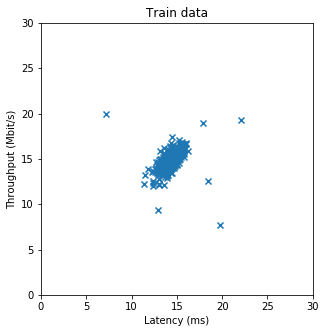

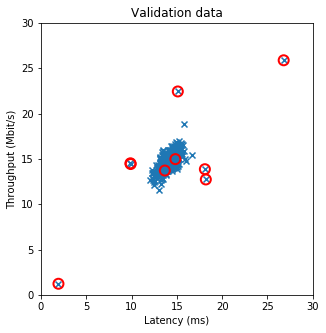

In [3]:
data = loadmat('data/anomaly1.mat')
X = data['X']
X_val, y_val = data['Xval'], data['yval'][:, 0]
plt.title('Train data')
plot_data(X)
plt.title('Validation data')
plot_data(X_val, y_val)

Utilizando modelo gaussiano multivariável para ajustar o conjunto de treinamento, primeiro estimamos a matriz de covariancia e média dos dados.

In [4]:
mean = np.mean(X,axis=0)
cov = np.cov(X,rowvar=False)
print("covariance:", cov)
print("mean: ", mean)

covariance: [[1.26174916 0.48988887]
 [0.48988887 1.48598517]]
mean:  [14.22064407 14.79786881]


Resultando no seguinte fit.

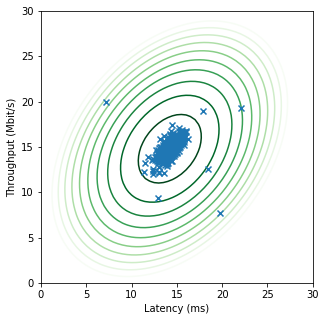

In [5]:
plot_data(X, None, mean, cov)

Sob hipótese de independência, foi estimado a variância de cada dimensão separadamente e produzida uma matriz de covariância diagonal.

In [6]:
var_0 = np.var(X[:,0])
var_1 = np.var(X[:,1])
diag = np.array([var_0,var_1])
np.diag(diag)

array([[1.25763923, 0.        ],
       [0.        , 1.48114483]])

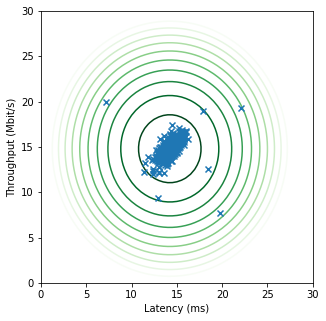

In [7]:
plot_data(X, None, mean, diag)

Qual estimação parece mais adequada? Por quê?

A primeira estimação com a matriz de covariância completa parece resultar num melhor fit para o conjunto de dados separando bem os outliers.

----

utilizando o método para retornar uma distribuição de probabilidades baseado numa normal multivariável, podemos detectar anomalias estimando adequadamente um limiar de decisão.

Inicialmente escolhemos arbitráriamente alguns valores de 'e' para observar a detecção.

epsilon: 0.001


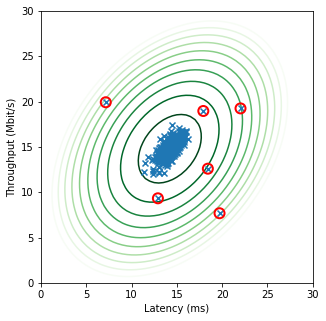

epsilon: 0.005


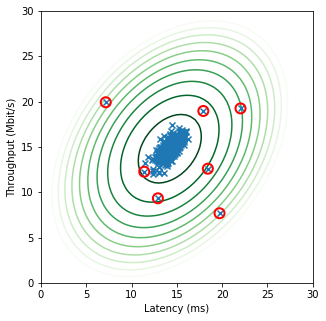

epsilon: 0.01


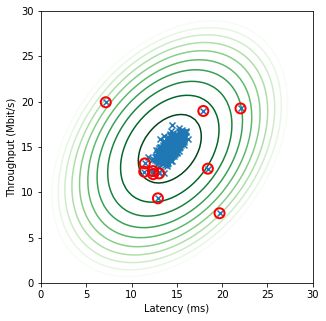

epsilon: 0.05


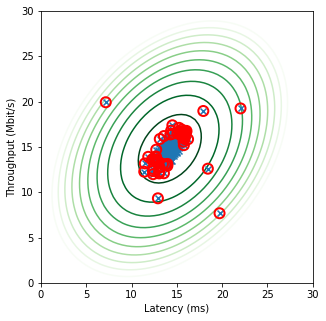

epsilon: 0.1


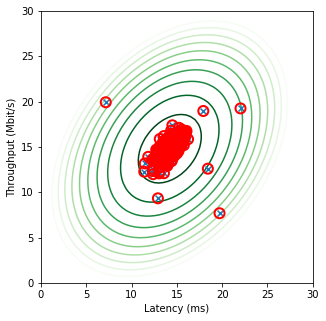

In [19]:
mean_val = np.mean(X_val, axis=0)
cov_val = np.cov(X_val, rowvar=False)

p = multivariate_normal(mean, cov).pdf(X)

epsilon = 0.002

for epsilon in [0.001, 0.005, 0.01, 0.05, 0.1]:
    print(f"epsilon: {epsilon}")
    y_pred = p < epsilon
    plot_data(X, y_pred, mean, cov)

Observamos que 'e' = 0.001 resultou no melhor linear.

Função para selecionar o melhor linear baseado no score F1.

In [20]:
def select_threshold(p,y):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0

    for epsilon in np.linspace(1.01*min(p), max(p), 1000):
        y_pred = p < epsilon    
        F1 = f1_score(y, y_pred)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

Utilizando a função para achar o melhor linear com o conjunto de validação, chegamos no seguinte resultado.

In [21]:
p = multivariate_normal(mean, cov).pdf(X)

p_val = multivariate_normal(mean, cov).pdf(X_val)

epsilon, f1 = select_threshold(p_val, y_val)

y_pred = p < epsilon

print("Epsilon: ", epsilon)
print("F1: ", f1)

Epsilon:  0.00012459071573165978
F1:  0.8750000000000001


Utilizando o valor de epsilon encontrado para detectar anomalias no conjunto de treinamento, chegamos no seguinte resultado.

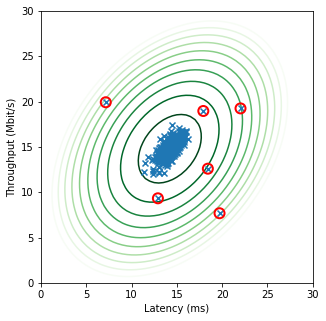

In [22]:
plot_data(X, y_pred, mean, cov)

Em vez de usar uma distribuição normal multivariável, utilizamos um envelope elíptico agora.

Variando o valor do parâmetro 'contamination', conseguimos o seguinte fit.

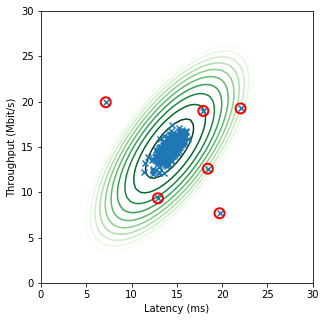

In [23]:
# contamination = y_val.mean()

model = EllipticEnvelope(contamination=0.017)
model.fit(X)

mean = model.location_
cov = model.covariance_

y_pred = model.predict(X)

y_pred = np.array([1 if x==-1 else 0 for x in y_pred])

plot_data(X, y_pred, mean, cov)

## Conjunto de Dados #2

In [24]:
data = loadmat('data/anomaly2.mat')
X = data['X']
X_val, y_val = data['Xval'], data['yval'][:, 0]
n = X.shape[1]
T = np.random.RandomState(0).randn(n,n)
X = X @ T
X_val = X_val @ T
print(X.shape, X_val.shape)

(1000, 11) (100, 11)


In [25]:
mean = np.mean(X,axis=0)
cov = np.cov(X,rowvar=False)
cov.shape ,mean.shape

((11, 11), (11,))

Agora com um novo conjunto de dados, calculamos o melhor epsilon, para maximizar o score F1, e printar a quantidade de outlier obtido.

### Estimação de covariância completa

In [26]:
p = multivariate_normal(mean, cov).pdf(X)

p_val = multivariate_normal(mean, cov).pdf(X_val)

epsilon, f1 = select_threshold(p_val, y_val)

outliers = np.sum(p < epsilon)

print("Epsilon: ", epsilon)
print("F1: ", f1)
print("Outliers: ", outliers)

Epsilon:  1.6650451888777096e-22
F1:  0.5517241379310345
Outliers:  122


### Estimação de covariância diagonal

In [27]:
def diagonal(X, n):
    variance = np.array([np.var(X[:,i]) for i in range(n)])
    return np.diag(variance)
    

cov = diagonal(X, X.shape[1])

In [28]:
p = multivariate_normal(mean, cov).pdf(X)

p_val = multivariate_normal(mean, cov).pdf(X_val)

epsilon, f1 = select_threshold(p_val, y_val)

outliers = np.sum(p < epsilon)

print("Epsilon: ", epsilon)
print("F1: ", f1)
print("Outliers: ", outliers)

Epsilon:  2.6466681119846214e-24
F1:  0.5185185185185185
Outliers:  193


Alterando o random state observamos que a variância de cada dimensão altera e com isso diminuí a correlação dos dados, resultando em scores F1 piores e maiores números de outliers.

In [29]:
for i in range(10):
    data = loadmat('data/anomaly2.mat')
    X = data['X']
    X_val, y_val = data['Xval'], data['yval'][:, 0]
    n = X.shape[1]
    T = np.random.RandomState(i).randn(n,n)
    X = X @ T
    X_val = X_val @ T
    
    p = multivariate_normal(mean, cov).pdf(X)

    p_val = multivariate_normal(mean, cov).pdf(X_val)

    epsilon, f1 = select_threshold(p_val, y_val)

    outliers = np.sum(p < epsilon)

    print(f"Epsilon {i}: ", epsilon)
    print(f"F1 {i}: ", f1)
    print(f"Outliers {i}: ", outliers)

Epsilon 0:  2.6466681119846214e-24
F1 0:  0.5185185185185185
Outliers 0:  193
Epsilon 1:  1.205949891428582e-25
F1 1:  0.37837837837837834
Outliers 1:  262
Epsilon 2:  7.17714013140466e-27
F1 2:  0.21978021978021975
Outliers 2:  865
Epsilon 3:  1.755892632524739e-25
F1 3:  0.2666666666666667
Outliers 3:  570
Epsilon 4:  1.1045623860780899e-24
F1 4:  0.23529411764705882
Outliers 4:  781
Epsilon 5:  7.412765580574904e-27
F1 5:  0.26666666666666666
Outliers 5:  574
Epsilon 6:  4.8056194249250224e-30
F1 6:  0.21052631578947367
Outliers 6:  810
Epsilon 7:  2.0418541310034008e-27
F1 7:  0.2068965517241379
Outliers 7:  773
Epsilon 8:  1.1987492729286708e-28
F1 8:  0.19417475728155342
Outliers 8:  882
Epsilon 9:  1.6288820331645918e-26
F1 9:  0.21505376344086022
Outliers 9:  804


### Modelo EllipticEnvelope do sklearn

In [31]:
model = EllipticEnvelope(contamination=0.122)
model.fit(X)

outliers = np.sum(model.predict(X) < 0)

print("Epsilon: ", epsilon)
print("F1: ", f1)
print("Outliers: ", outliers)

Epsilon:  1.6288820331645918e-26
F1:  0.21505376344086022
Outliers:  122


## Sistemas de Recomendação

In [32]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

Utilizando a ferramenta surprise para o conjunto de dados movielens-100k, com o algoritmo SVD, conseguimos o seguinte resultado.

In [33]:
# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9376  0.9342  0.9390  0.9420  0.9279  0.9361  0.0048  
MAE (testset)     0.7385  0.7362  0.7391  0.7438  0.7301  0.7375  0.0045  
Fit time          4.48    4.66    4.39    4.36    4.33    4.44    0.12    
Test time         0.11    0.12    0.15    0.11    0.11    0.12    0.02    


{'fit_time': (4.475809335708618,
  4.658260822296143,
  4.390162944793701,
  4.36432671546936,
  4.33440375328064),
 'test_mae': array([0.73854552, 0.73616086, 0.73911847, 0.74380243, 0.73010556]),
 'test_rmse': array([0.93758751, 0.93416417, 0.93901077, 0.9419927 , 0.92788036]),
 'test_time': (0.11405587196350098,
  0.11691427230834961,
  0.15259242057800293,
  0.10970640182495117,
  0.11170315742492676)}

Testando o sistema de recomendação, fazendo a predição de um id de usuário para o id de um filme, chegamos ao seguinte resultado.

In [34]:
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(302)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=None, verbose=True)

user: 196        item: 302        r_ui = None   est = 4.07   {'was_impossible': False}


Testando a versão unbiased do algoritmo, verificamos o seguinte:

In [35]:
algo = SVD(biased=False)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9427  0.9613  0.9481  0.9405  0.9597  0.9505  0.0085  
MAE (testset)     0.7449  0.7570  0.7473  0.7409  0.7547  0.7489  0.0060  
Fit time          4.31    4.37    4.34    4.34    4.33    4.34    0.02    
Test time         0.13    0.10    0.10    0.13    0.13    0.12    0.02    


{'fit_time': (4.309472322463989,
  4.371304273605347,
  4.335402250289917,
  4.341418266296387,
  4.331409215927124),
 'test_mae': array([0.74485018, 0.75703919, 0.74730599, 0.74086395, 0.754663  ]),
 'test_rmse': array([0.94274104, 0.96125596, 0.94811855, 0.94054888, 0.95965121]),
 'test_time': (0.13463854789733887,
  0.09773921966552734,
  0.09773874282836914,
  0.13364481925964355,
  0.13464117050170898)}

Prevendo novamente para outro usuário e filme.

In [36]:
uid = str(547)  # raw user id (as in the ratings file). They are **strings**!
iid = str(740)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=None, verbose=True)

user: 547        item: 740        r_ui = None   est = 3.10   {'was_impossible': False}
